### <center> The purpose of this notebook is to create the coastal and tropical masks for each S2S and observational product in a way that a correct kelvin-wave pathway can be extracted from the global data.

There are four global grids to consider:
* ASCAT/QuikSCAT, ERA5 and TOPEX/POSEIDON 0.25°x0.25° grid
* GLORYS12V1 0.08°x0.08° grid
* S2S 1°x1° grid
*

For each of these global grids the notebook has a section dedicated to the mask building. The idea is to grab 3 masks per product, one for the tropical band (2°S - 2°N), one for the western north america coastal band and another for the western south america coastal band. 

Since S2S forecasts are on a 1°x1° global grid, a single pixel will be used for evaluating the skill along the coast. A similar masks of the same extent (1°) will be buildt based on the global grid of the higher resolution produts. For instance, since GLORYS12V1 is on a 1/12° grid, 12 pixels will be used for building the coastal masks. For ASCAT only 4 pixels will be used.

In [1]:

from glob import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.signal as signal
from scipy.interpolate import interp1d
import os

---

#### <center> ECMWF S2S REFORECASTS


In [5]:
# Load a single file
reforecast = xr.open_dataset('data/S2S/REFORECASTS/ensamble0/2020-01-06/2000-01-06_O2D.nc')
reforecast = reforecast.sortby('lat').sortby('lon').sel({'lon':slice(110,290),'lat':slice(-40,40)})
reforecast = reforecast.assign_coords({'i':('lat',range(len(reforecast.lat))),'j':('lon',range(len(reforecast.lon)))})
lon,lat = np.meshgrid(reforecast.lon,reforecast.lat) # Get grid
reforecast

<xarray.Dataset>
Dimensions:       (time: 46, lon: 181, lat: 81, depth: 1, depth_2: 1, bnds: 2)
Coordinates:
  * time          (time) datetime64[ns] 2000-01-07 2000-01-08 ... 2000-02-21
  * lon           (lon) float32 110.0 111.0 112.0 113.0 ... 288.0 289.0 290.0
  * lat           (lat) float32 -40.0 -39.0 -38.0 -37.0 ... 37.0 38.0 39.0 40.0
  * depth         (depth) float64 0.0
  * depth_2       (depth_2) float64 150.0
    i             (lat) int64 0 1 2 3 4 5 6 7 8 9 ... 72 73 74 75 76 77 78 79 80
    j             (lon) int64 0 1 2 3 4 5 6 7 ... 174 175 176 177 178 179 180
Dimensions without coordinates: bnds
Data variables:
    depth_2_bnds  (depth_2, bnds) float64 ...
    dslm          (time, depth, lat, lon) float32 ...
    param18.4.10  (time, depth_2, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Tue Jul 25 15:54:58 2023: cdo -f nc copy 2000-01-06.grb REF...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...

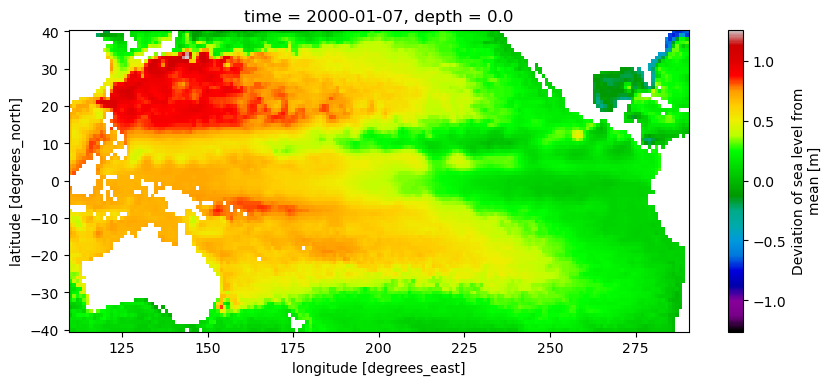

In [6]:
# Snapshot to sea level at initialization time
fig = plt.figure(figsize=(10,4), dpi=100, facecolor='w')
reforecast['dslm'].isel(time=0).plot(cmap='nipy_spectral')

In [7]:
# Build tropical mask
tropicalmask = reforecast.dslm[0,0,:,:].where(reforecast.lat>=-2).where(reforecast.lat<=2)
tropicalmask = xr.where(~np.isnan(tropicalmask),1,0).to_dataset(name='tropicalmask').drop('j').drop('i')
tropicalmask = tropicalmask.sel(lon=slice(140,291))

In [8]:
# Build coastal mask

watermask = reforecast.dslm[0,0,:,:].fillna(-9999).sel(lon=slice(220,290)) # Get water pixels
watermask = watermask.assign_coords({'i':('lat',range(len(watermask.lat))),'j':('lon',range(len(watermask.lon)))}) # Assign indexes to lat,lon coords
watermask = xr.where(watermask==-9999,0,1) # Get water pixels as 0/1 values
watermask = watermask.differentiate('lon')!=0 # Get coastline
watermask = watermask.where(watermask).ffill('lon') # Mask out all pixels after western america coastline
x = xr.concat([watermask[i,:].dropna('lon').isel(lon=0).j for i in range(len(watermask.lat))],'lat') # Coastline latitude
watermask = xr.where(watermask==9999,1,0) # Set everything to 0
watermask[:,x[:]] = 1 # Set coastline to true

# Set some pixels to True by "hand" for coastline continuity
watermask[23,[65,67]]=1
watermask[33,58]=1
watermask[37,58]=1
watermask[47,[58,59,60]]=1
watermask[48,56]=1
watermask[53,[48,49,50]]=1
watermask[55,[42,43,44,45]]=1
watermask[55,[42,43,44,45]]=1
watermask[56,[39,40]]=1
watermask[58,[35,36,37]]=1
watermask[62,[29,30,31,32]]=1
watermask[64,27]=1
watermask[74,19]=1
watermask[37,59]=1
watermask[33,59]=1
watermask[23,[66,68]]=1
watermask[47,[57,61]]=1
watermask[48,[57]]=1
watermask[53,[51]]=1
watermask[55,[46]]=1
watermask[56,[41]]=1
watermask[62,[33]]=1
watermask[64,[28]]=1
watermask[74,[20]]=1

watermask = watermask.where(abs(reforecast.lat)>2).fillna(0) # Set tropical band to false
# Grab southern and northern hemisphere coastal masks
coastmask_south = watermask.sel(lat=slice(-90,-2)).reindex({'lat':tropicalmask.lat,'lon':tropicalmask.lon}).fillna(0).to_dataset(name='coastmask_south').drop('j').drop('i')
coastmask_north = watermask.sel(lat=slice(2,90)).reindex({'lat':tropicalmask.lat,'lon':tropicalmask.lon}).fillna(0).to_dataset(name='coastmask_north').drop('j').drop('i')

In [9]:
# Merge everything and drop useless coordinates
masks = xr.merge([tropicalmask,coastmask_south,coastmask_north]).drop(['depth','time'])
masks = masks.sel(lat=slice(-40,40))
masks

<xarray.Dataset>
Dimensions:          (lon: 151, lat: 81)
Coordinates:
  * lon              (lon) float32 140.0 141.0 142.0 143.0 ... 288.0 289.0 290.0
  * lat              (lat) float32 -40.0 -39.0 -38.0 -37.0 ... 38.0 39.0 40.0
Data variables:
    tropicalmask     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    coastmask_south  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    coastmask_north  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

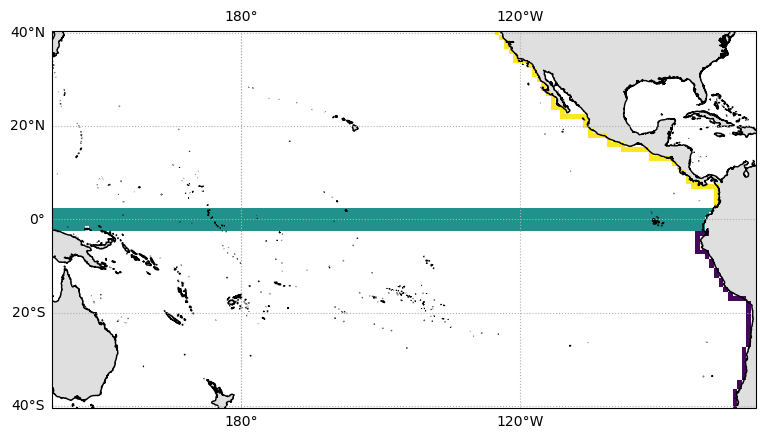

In [10]:
# Quick look to the new masks
fig = plt.figure(figsize=(10,5), dpi=100, facecolor='w')
ax  = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=140))
ax.coastlines('10m')
ax.add_feature(cf.LAND, color='silver', alpha=0.5)
ax.gridlines(draw_labels=True, linestyle=":")
(masks.tropicalmask.where(masks.tropicalmask==1)).plot(add_colorbar=False, vmin=1,vmax=1, ax=ax, transform=ccrs.PlateCarree())
(masks.coastmask_north.where(masks.coastmask_north==1)+1).plot(add_colorbar=False, vmin=1, vmax=2, ax=ax, transform=ccrs.PlateCarree())
(masks.coastmask_south.where(masks.coastmask_south==1)+2).plot(add_colorbar=False, vmin=1, vmax=100, ax=ax, transform=ccrs.PlateCarree())

As we can see in the previous figure, three interesting masks has been made:
* Green: Tropical mask from 2°S to 2°N for all the pacific basin (west of 180°E there is some land!! so be carefull) 
* Yellow: Western North America coastal mask, ranging from Ecuador to the US, skipping the Gulf of California.
* Dark Purple: Western South America coastal mask ranging from Ecuador to Chile

Now some attributes will be added and the new mask dataset stored on disk

In [11]:
# Add some attributes
masks.attrs = {'name':'S2S KW Masks',
               'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
               'description':'Tropical and coastal masks for the eastern pacific based on the S2S ocean forecast dataset',
               'author':'Lucas Glasner',
               'contact':'lucas.glasner@ceaza.cl'}
masks.tropicalmask.attrs    = {'short_name':'tropicalmask','long_name':'1°x1° Tropical Mask'}
masks.coastmask_south.attrs = {'short_name':'coastmask_south','long_name':'SE Pacific Coastal mask for SouthAmerica'}
masks.coastmask_north.attrs = {'short_name':'coastmask_north','long_name':'SE Pacific Coastal mask for NorthAmerica'}

In [12]:
#masks.to_netcdf('data/S2S_masks.nc')

---

### <center> MERCATOR GLORYS12V1 Ocean Reanalysis

Since GLORYS12V1 is a 1/12° resolution dataset there are alot of nooks and turnarounds along the coast. For that reason a different approach will be used. 
A 10m land polygon from Natural Earth dataset has been downloaded. With the polygon a coastline mask will be constructed taking account 12 valid pixels of GLORYS12V1 dataset. 

<AxesSubplot:>

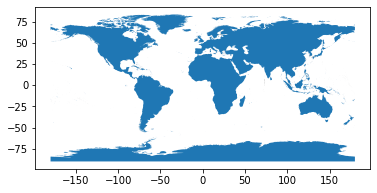

In [13]:
# Load the global land polygon
import geopandas as gpd
import regionmask
coastline = gpd.read_file('data/NaturalEarth_Polygons/ne_10m_land.shp')
coastline.plot()

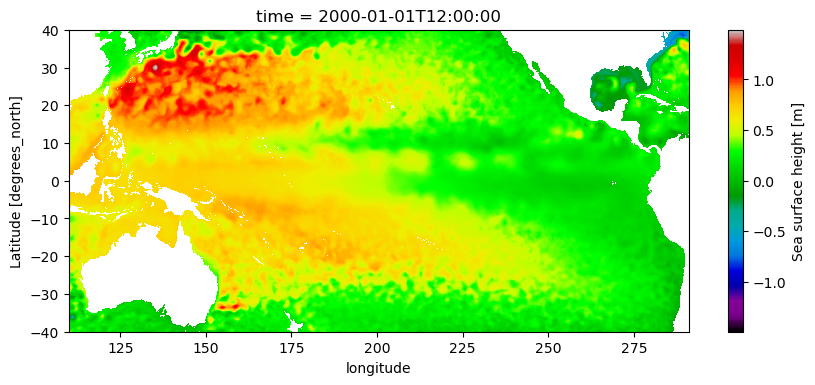

In [14]:
# Open a dummy GLORYS12V1 dataset with the domain characteristics
glorys = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/domain.nc').zos
glorys.coords['longitude'] = xr.where(glorys.longitude<0, glorys.longitude+360, glorys.longitude)
glorys = glorys.sortby('longitude').sel(longitude=slice(110,291))
# glorys.coords['longitude'] = (glorys.longitude+180)%360-180
# glorys = glorys.sortby('longitude')
glorys.coords['i'] = ('latitude',np.arange(len(glorys.latitude)))
glorys.coords['j'] = ('longitude', np.arange(len(glorys.longitude)))

# Plot a snapshot of sea surface heights
fig = plt.figure(figsize=(10,4), dpi=100, facecolor='w')
glorys.plot(cmap='nipy_spectral')

In [15]:
# Tropical mask
tropicalmask = glorys.where(glorys.latitude>-2).where(glorys.latitude<2).drop(['i','j','time'])>-9999
tropicalmask = tropicalmask.sel(longitude=slice(140,291))

In [16]:
ref  = glorys.sel(longitude=slice(225,291)) # Grab a slice near the east pacific
mask = regionmask.mask_geopandas(coastline, ref.longitude, ref.latitude)==0 # Use the polygon to create water/land mask
mask = mask.astype(float).differentiate('j') # Grab the coastline
mask = mask>0 # Binarize data
mask = ((mask.where(mask).ffill('longitude'))==1).astype(float).differentiate('j') # Remove everything eastward of the western coastline
mask = mask.where(mask).bfill('longitude', limit=12-2)==0.5 # Expand the coastline to a coastal band of 12 pixels

# Remove tropical band and split mask in the norther/southern hemispheres
coastmask_north = xr.where(mask.latitude>2, mask, 0).drop(['i','j','time'])
coastmask_south = xr.where(mask.latitude<-2, mask,0).drop(['i','j','time'])

In [17]:
# Merge everything
masks = xr.merge([tropicalmask.to_dataset(name='tropicalmask'),
                  coastmask_north.to_dataset(name='coastmask_north'),
                  coastmask_south.to_dataset(name='coastmask_south')]).astype(float).fillna(0)
masks = masks.rename({'latitude':'lat','longitude':'lon'})

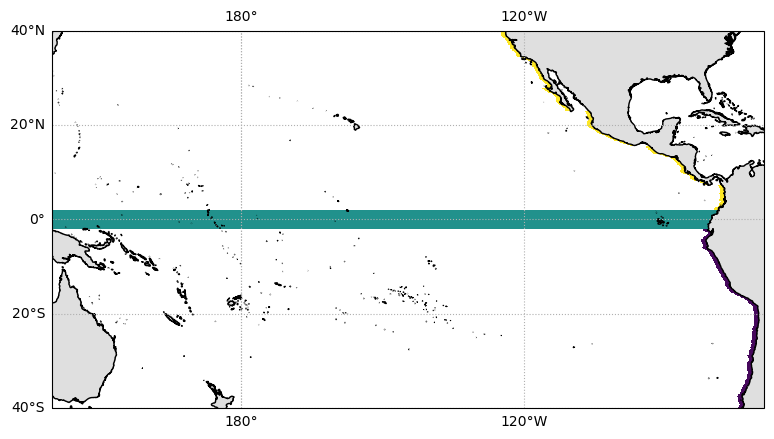

In [18]:
# Quick look to the new masks
fig = plt.figure(figsize=(10,5), dpi=100, facecolor='w')
ax  = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines('10m')
ax.add_feature(cf.LAND, color='silver', alpha=0.5)
ax.gridlines(draw_labels=True, linestyle=":")
(masks.tropicalmask.where(masks.tropicalmask==1)).plot(add_colorbar=False, vmin=1,vmax=1, ax=ax, transform=ccrs.PlateCarree())
(masks.coastmask_north.where(masks.coastmask_north==1)+1).plot(add_colorbar=False, vmin=1, vmax=2, ax=ax, transform=ccrs.PlateCarree())
(masks.coastmask_south.where(masks.coastmask_south==1)+2).plot(add_colorbar=False, vmin=1, vmax=100, ax=ax, transform=ccrs.PlateCarree())

As we can see in the previous figure, the same masks have been made, but with the GLORYS12V1 Grid:
* Green: Tropical mask from 2°S to 2°N for all the pacific basin
* Yellow: Western North America coastal mask, ranging from Ecuador to the US, skipping the Gulf of California.
* Dark Purple: Western South America coastal mask ranging from Ecuador to Chile

There are some minor differences, specially in the northern hemisphere, where some discontinuities can be seen in the central america/mexico transition and in the Gulf of California. 
Since the focus of this study is the tropical band and the souther hemisphere the mask design look succesful. 

Now some attributes will be added and the masks will be stored on disk.

In [19]:
# Add some attributes
masks.attrs = {'name':'GLORYS12V1 0.08°x0.08° KW Masks',
               'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
               'description':'Tropical and coastal masks for the eastern pacific based on the GLORYS12V1 Reanalysis',
               'author':'Lucas Glasner',
               'contact':'lucas.glasner@ceaza.cl'}
masks.tropicalmask.attrs    = {'short_name':'tropicalmask','long_name':'Tropical Band Mask'}
masks.coastmask_south.attrs = {'short_name':'coastmask_south','long_name':'SE Pacific Coastal mask for SouthAmerica'}
masks.coastmask_north.attrs = {'short_name':'coastmask_north','long_name':'SE Pacific Coastal mask for NorthAmerica'}
masks.lat.attrs             = {'short_name':'lat', 'long_name':'latitude','units':'degrees_north'}
masks.lon.attrs             = {'short_name':'lon', 'long_name':'longitude','units':'degrees_east'}

In [20]:
#masks.drop_indexes(['lon','lat']).to_netcdf('data/GLORYS_masks.nc')

---

### <center> ASCAT/QuikSCAT surface winds from satellite scatterometers

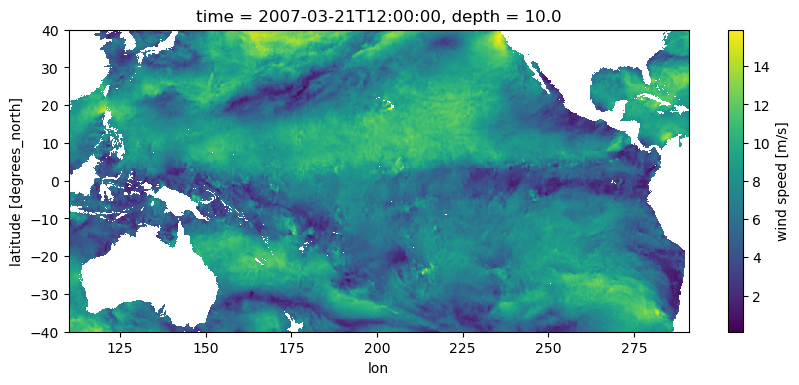

In [21]:
ascat    = xr.open_dataset('data/ASCAT/2007032100_2007032200_daily-ifremer-L3-MWF-GLO-20110531232401-01.0.nc')
ascat    = ascat['wind_speed'].squeeze().rename({'longitude':'lon','latitude':'lat'})
ascat.coords['lon'] = xr.where(ascat.lon<0, ascat.lon+360, ascat.lon)
ascat    = ascat.sortby('lon').sel(lon=slice(110,291), lat=slice(-40,40))
ascat.coords['i'] = ('lat', np.arange(len(ascat.lat)))
ascat.coords['j'] = ('lon', np.arange(len(ascat.lon)))
# Plot snapshot of 10m winds
plt.figure(figsize=(10,4), dpi=100, facecolor='w')
ascat.plot()

In [22]:
# Tropical mask
tropicalmask = ascat.where(ascat.lat>-2).where(ascat.lat<2).drop(['i','j','time','depth'])>-9999
tropicalmask = tropicalmask.sel(lon=slice(140,291))

In [23]:
ref  = ascat.sel(lon=slice(225,291)) # Grab a slice near the east pacific
mask = regionmask.mask_geopandas(coastline, ref.lon, ref.lat)==0 # Use the polygon to create water/land mask
mask = mask.astype(float).differentiate('j') # Grab the coastline
mask = mask>0 # Binarize data
mask = ((mask.where(mask).ffill('lon'))==1).astype(float).differentiate('j') # Remove everything eastward of the western coastline
mask = mask.where(mask).bfill('lon', limit=2)==0.5 # Expand the coastline to a coastal band of 4 pixels

# Remove tropical band and split mask in the norther/southern hemispheres
coastmask_north = xr.where(mask.lat>2, mask, 0).drop(['i','j','time'])
coastmask_south = xr.where(mask.lat<-2, mask,0).drop(['i','j','time'])

In [24]:
# Merge everything
masks = xr.merge([tropicalmask.to_dataset(name='tropicalmask'),
                  coastmask_north.to_dataset(name='coastmask_north'),
                  coastmask_south.to_dataset(name='coastmask_south')]).astype(float).fillna(0).drop('depth')
masks

<xarray.Dataset>
Dimensions:          (lat: 320, lon: 604)
Coordinates:
  * lon              (lon) float64 140.1 140.4 140.6 140.9 ... 290.4 290.6 290.9
  * lat              (lat) float32 -39.88 -39.62 -39.38 ... 39.38 39.62 39.88
Data variables:
    tropicalmask     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    coastmask_north  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    coastmask_south  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

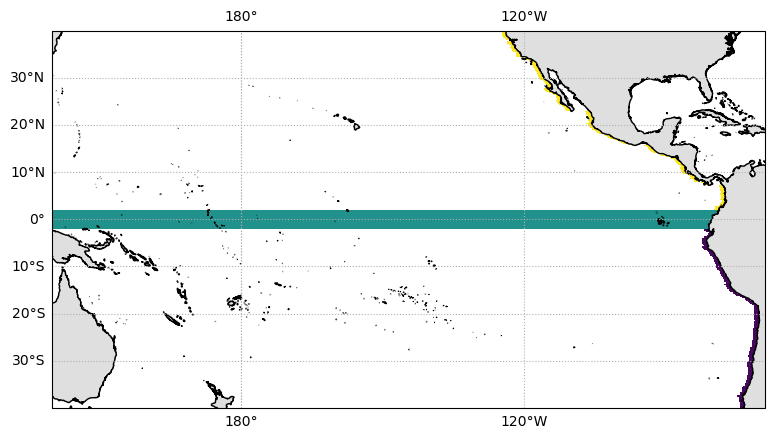

In [25]:
# Quick look to the new masks
fig = plt.figure(figsize=(10,5), dpi=100, facecolor='w')
ax  = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines('10m')
ax.add_feature(cf.LAND, color='silver', alpha=0.5)
ax.gridlines(draw_labels=True, linestyle=":")
(masks.tropicalmask.where(masks.tropicalmask==1)).plot(add_colorbar=False, vmin=1,vmax=1, ax=ax, transform=ccrs.PlateCarree())
(masks.coastmask_north.where(masks.coastmask_north==1)+1).plot(add_colorbar=False, vmin=1, vmax=2, ax=ax, transform=ccrs.PlateCarree())
(masks.coastmask_south.where(masks.coastmask_south==1)+2).plot(add_colorbar=False, vmin=1, vmax=100, ax=ax, transform=ccrs.PlateCarree())

Same story as before, but know the masks where built from the native 0.25°x0.25° ASCAT grid.
Now some attributes will be added and the masks dataset will be saved on disk.

In [26]:
# Add some attributes
masks.attrs = {'name':'QuikSCAT/ASCAT 0.25°x0.25° KW Masks',
               'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
               'description':'Tropical and coastal masks for the eastern pacific based on the ASCAT mission',
               'author':'Lucas Glasner',
               'contact':'lucas.glasner@ceaza.cl'}
masks.tropicalmask.attrs    = {'name':'tropicalmask','long_name':'Tropical Band Mask'}
masks.coastmask_south.attrs = {'name':'coastmask_south','long_name':'SE Pacific Coastal mask for SouthAmerica'}
masks.coastmask_north.attrs = {'name':'coastmask_north','long_name':'SE Pacific Coastal mask for NorthAmerica'}
masks.lat.attrs             = {'short_name':'lat', 'long_name':'latitude','units':'degrees_north'}
masks.lon.attrs             = {'short_name':'lon', 'long_name':'longitude','units':'degrees_east'}

In [27]:
#masks.drop_indexes(['lon','lat']).to_netcdf('data/ASCAT_masks.nc')

---
### <center> 

---

### <center> Final plots of new created masks

In [2]:
masks_S2S    = xr.open_dataset('data/S2S_masks.nc')
masks_GLORYS = xr.open_dataset('data/GLORYS_masks.nc')
masks_ASCAT  = xr.open_dataset('data/ASCAT_masks.nc')

/home/lucas/miniconda3/envs/forecast/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


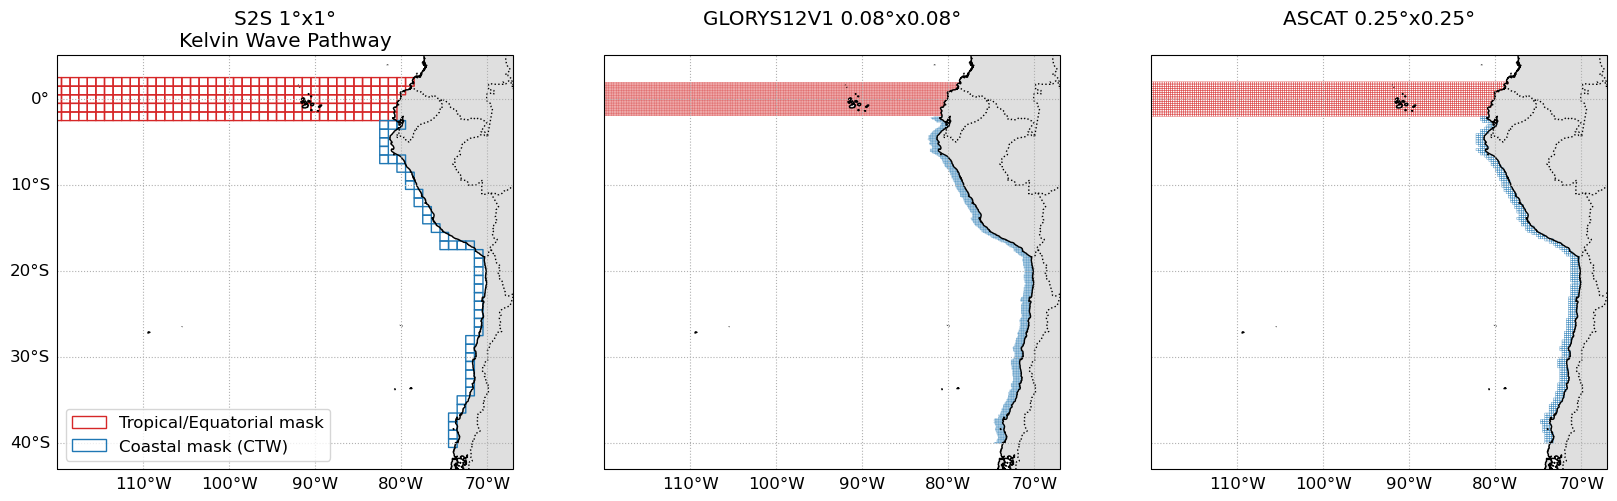

In [29]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True,
                       subplot_kw={'projection':ccrs.PlateCarree()},
                       figsize=(20,10), facecolor='w', dpi=100)
plt.rc('font', size=12)
variables  = [masks_S2S, masks_GLORYS, masks_ASCAT]
linewidths = [1, 1/12, 1/4]
for i,axis in enumerate(ax.ravel()):
    axis.set_extent([-120,-67,-40,5])
    axis.coastlines('10m')
    axis.add_feature(cf.LAND, color='silver', alpha=0.5)
    axis.add_feature(cf.BORDERS, color='k', linestyle=":")
    gl = axis.gridlines(linestyle=":", draw_labels=True)
    gl.top_labels   = False
    gl.right_labels = False
    if i!=0:
        gl.left_labels = False
    
    x = variables[i]
    axis.pcolor(x.lon, x.lat,x.tropicalmask.where(x.tropicalmask==1),
                facecolor='none', edgecolor='tab:red', lw=linewidths[i],
                label='Tropical/Equatorial mask', transform=ccrs.PlateCarree())
    axis.pcolor(x.lon, x.lat, x.coastmask_south.where(x.coastmask_south==1),
                facecolor='none', edgecolor='tab:blue', lw=linewidths[i],
                label='Coastal mask (CTW)', transform=ccrs.PlateCarree())

ax[0].set_title('S2S 1°x1°\nKelvin Wave Pathway');
ax[1].set_title('GLORYS12V1 0.08°x0.08°\n');
ax[2].set_title('ASCAT 0.25°x0.25°\n');
ax[0].legend(loc='lower left')
    

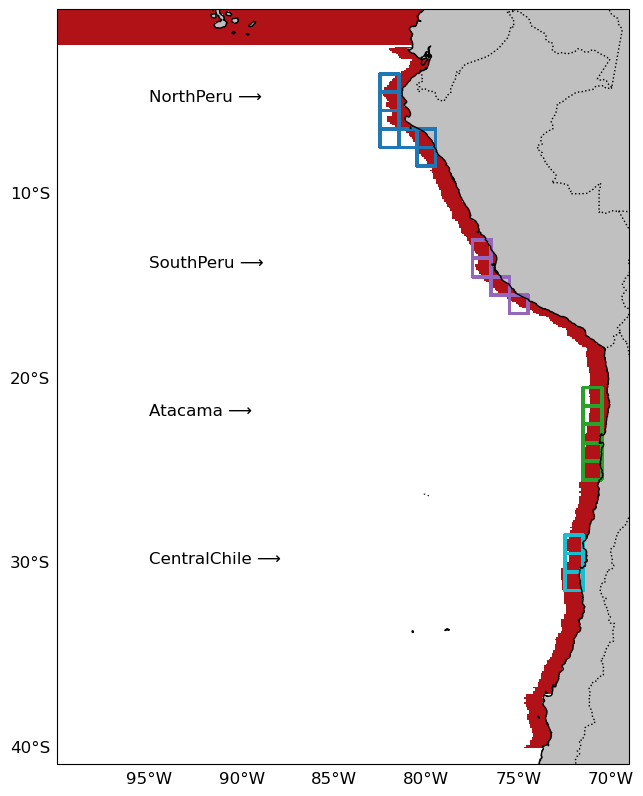

In [30]:
zones_south = {'NorthPeru':slice(-4,-8),
               'SouthPeru':slice(-13,-16),
               'Atacama':slice(-21,-25),
               'CentralChile':slice(-29,-31)}

points = {'Piura':(-5.17, -80.65),
          'Pisco':(-13.71, -76.19),
          'Antofagasta':(-23.59, -70.39),
          'Coquimbo':(-29.95,-71.35)}

fig, ax = plt.subplots(1,1, figsize=(10,10), dpi=100, facecolor='w', subplot_kw={'projection':ccrs.PlateCarree()})
plt.rc('font', size=12)
ax.coastlines('10m')
ax.set_extent([-100,-69,-40,0])
masks_GLORYS.tropicalmask.where(masks_GLORYS.tropicalmask).plot(ax=ax, add_colorbar=False, vmin=0, vmax=1.2, cmap='Reds')
masks_GLORYS.coastmask_south.where(masks_GLORYS.coastmask_south).plot(ax=ax, add_colorbar=False, vmin=0, vmax=1.2, cmap='Reds')
ax.add_feature(cf.LAND, color='silver')
ax.add_feature(cf.BORDERS, ls=':')
gl=ax.gridlines(draw_labels=True, linewidth=0)
gl.right_labels=False
gl.top_labels=False

colors=plt.cm.tab10(np.linspace(0,1,10))[[0,4,2,9],:]
for i,z in enumerate(zones_south.keys()):    
    x = masks_S2S.coastmask_south.sortby('lat',ascending=False).sel(lat=zones_south[z])
    x = x.where(x==1)
    ax.pcolor(x.lon,x.lat,x, color=colors[i], facecolor='none', linewidth=2)
    ax.text(-95, x.lat[1], '{} ⟶'.format(z), transform=ax.transData)
    
# markers = ['o','s','^','d']
# for p,m in zip(points.keys(), markers):
#     ax.scatter(points[p][1], points[p][0], s=100, marker=m,
#                edgecolor='k',
#                transform=ccrs.PlateCarree(),
#                zorder=100,
#                label=p)
# ax.legend()
